# Project 1: Kernelized Linear Classification

**Goal**:  
- Explore and preprocess the dataset.  
- Implement (from scratch) and compare:
  1. Linear Perceptron  
  2. Pegasos SVM (linear)  
  3. Pegasos Logistic (linear)  
  4. Kernel Perceptron (Gaussian & Polynomial)  
  5. Kernel Pegasos SVM (Gaussian & Polynomial)  

**Evaluation Metric**: 0–1 loss (equivalently, **accuracy**).  
We'll also watch out for **overfitting/underfitting** and carefully handle **data leakage** issues.

In [22]:
import sys
sys.path.append("/Users/michelecoaro/Documents/GitHub/KLC/klc_project/code/functions.py")

In [41]:
###########################################################
# Cell 1: Imports & Setup
###########################################################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# If using local 'functions.py' with classes:
from ml_functions import (
    to_pm1_labels,
    accuracy_score,
    zero_one_loss,
    polynomial_feature_expansion,
    Perceptron,
    PegasosSVM,
    PegasosLogistic,
    KernelPerceptron,
    KernelPegasosSVM
)

# Set some plotting style preferences (optional)
sns.set_theme(style="whitegrid")


## Cell 2: Load and Inspect Dataset

We'll load the CSV data, do basic checks, ensure no data leakage, 
and explore data distribution. 


In [24]:
###########################################################
# Cell 2: Load & Basic EDA
###########################################################

# Replace "your_dataset.csv" with the actual file name or path
df = pd.read_csv("/Users/michelecoaro/Documents/GitHub/KLC/klc_project/dataset.csv")

print("DataFrame shape:", df.shape)
df.head()


DataFrame shape: (10000, 11)


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,1.205492,5.823226,98.837539,-1.075852,0.999205,0.911543,3.623558,-1.720267,-0.346191,-54.708330,-1
1,1.391530,3.611581,98.857197,-5.020318,0.677165,0.999492,3.413112,4.253865,2.041603,-54.317291,1
2,1.692571,-0.887019,100.901276,-0.595548,0.177550,-0.915495,4.320264,0.907834,3.126815,-56.397484,-1
3,4.289320,1.416843,100.784735,-2.897154,-0.066972,-0.786173,2.093003,1.336237,2.183829,-56.197728,1
4,0.542420,-1.010095,100.015580,-3.070705,0.088324,-0.242669,0.767942,-0.284683,-2.104145,-55.794045,1


In [25]:
df.describe

<bound method NDFrame.describe of             x1        x2          x3        x4        x5        x6        x7  \
0     1.205492  5.823226   98.837539 -1.075852  0.999205  0.911543  3.623558   
1     1.391530  3.611581   98.857197 -5.020318  0.677165  0.999492  3.413112   
2     1.692571 -0.887019  100.901276 -0.595548  0.177550 -0.915495  4.320264   
3     4.289320  1.416843  100.784735 -2.897154 -0.066972 -0.786173  2.093003   
4     0.542420 -1.010095  100.015580 -3.070705  0.088324 -0.242669  0.767942   
...        ...       ...         ...       ...       ...       ...       ...   
9995  0.481134 -0.572225   99.274788 -0.868047 -0.663229  0.572447  5.163238   
9996  0.047373  0.990198  100.444834 -0.707179  0.912113 -0.510397  1.128577   
9997  1.741933  0.036304  100.524071 -0.113742 -0.761337 -0.728295 -1.334732   
9998  2.574986  0.041442   98.983735 -1.937883  0.983004  0.798133  5.847342   
9999  0.123523 -1.518412   99.159300 -2.024888  0.785601  0.745629 -0.457173   

     

In [26]:
# Check for missing values
print(df.isnull().sum())

# If needed, handle missing values here, e.g., dropping or imputing
# df.dropna(inplace=True)  # Example if dropping incomplete rows


x1     0
x2     0
x3     0
x4     0
x5     0
x6     0
x7     0
x8     0
x9     0
x10    0
y      0
dtype: int64


Unique labels: [-1  1]
y
-1    5008
 1    4992
Name: count, dtype: int64


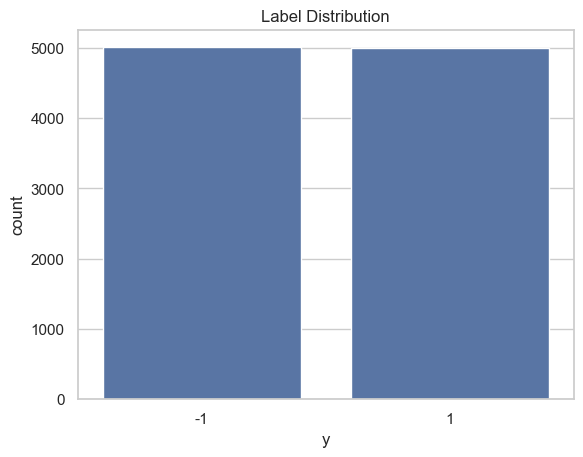

In [27]:
# Quick look at the distribution of the target (y)
target_col = "y"  # Replace if your label column is named differently
print("Unique labels:", df[target_col].unique())
print(df[target_col].value_counts())

# Visualize target distribution
sns.countplot(x=target_col, data=df)
plt.title("Label Distribution")
plt.show()


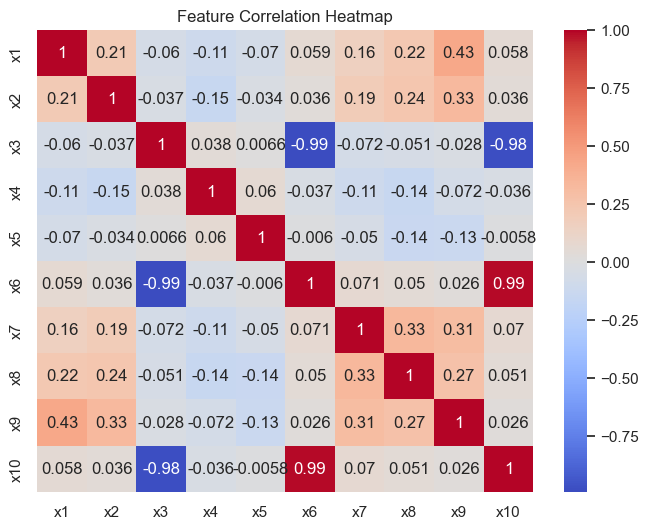

In [28]:
# If you have purely numerical features, you can check correlations.
# Example (drop the target if it's numeric in 0/1, or keep if you want to see correlation with y):
features_only = df.drop(columns=[target_col])
corr_matrix = features_only.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


### Observations
- Summarize your EDA findings:
  - Are there outliers?
  - Any strong correlation between features?
  - Imbalanced labels?
  - Missing data?

We must keep these in mind when deciding how to preprocess, split, etc.


## Cell 3: Data Preprocessing & Splitting

- Convert labels from `{0,1}` to `{-1,+1}` if necessary.  
- Train/Validation/Test Split (to avoid data leakage).  
- (Optional) Standardize features (fit only on training, transform on test).


In [29]:
###########################################################
# Cell 3: Data Preprocessing & Splitting
###########################################################

# 1) Separate features (X) and target (y)
X_df = df.drop(columns=[target_col])
y_df = df[target_col].values

# Convert y to {+1, -1} using the helper
y_converted = to_pm1_labels(y_df)

X = X_df.values  # as a numpy array

# 2) Train/Test split (we'll also create a validation set, if desired).
#    We'll do a manual approach (without sklearn) to show no data leakage.

# Shuffle the data first
rng = np.random.default_rng(seed=42)  # for reproducible shuffling
indices = rng.permutation(len(X))
train_size = int(0.7 * len(X))
val_size   = int(0.15 * len(X))  # for example, 15% validation
test_size  = len(X) - train_size - val_size

train_idx = indices[:train_size]
val_idx   = indices[train_size:train_size+val_size]
test_idx  = indices[train_size+val_size:]

X_train, y_train = X[train_idx], y_converted[train_idx]
X_val,   y_val   = X[val_idx],   y_converted[val_idx]
X_test,  y_test  = X[test_idx],  y_converted[test_idx]

print(f"Train size: {len(X_train)}, Val size: {len(X_val)}, Test size: {len(X_test)}")


Train size: 7000, Val size: 1500, Test size: 1500


In [30]:
# 3) (Optional) Feature scaling (e.g., standardization) to avoid data leakage:
#    Fit mean/std only on TRAIN; transform val and test with same stats.

def standard_scaler_fit(X):
    mean = X.mean(axis=0)
    std = X.std(axis=0, ddof=1)
    return mean, std

def standard_scaler_transform(X, mean, std):
    # Avoid division by zero for zero std features
    std_no_zero = np.where(std == 0, 1, std)
    return (X - mean) / std_no_zero

mean_, std_ = standard_scaler_fit(X_train)
X_train_scaled = standard_scaler_transform(X_train, mean_, std_)
X_val_scaled   = standard_scaler_transform(X_val, mean_, std_)
X_test_scaled  = standard_scaler_transform(X_test, mean_, std_)


### Verification
- We have **train**, **val**, and **test** sets.  
- We fit any transformations only on **train**. 
- No data leakage from test into training. 
- Next, we can attempt polynomial expansion if needed.


## Cell 4: Polynomial Feature Expansion (Degree 2)

We’ll demonstrate the polynomial expansion of the numerical features:
- Important to expand **after** the train/val/test split, to avoid leakage.
- If we do polynomial expansions, we might want to re-scale, because polynomial expansions can grow large.


In [31]:
###########################################################
# Cell 4: Polynomial Feature Expansion
###########################################################

# Example: If you want to see how expansions would work, do:
X_train_poly = polynomial_feature_expansion(X_train_scaled, degree=2, include_bias=True)
X_val_poly   = polynomial_feature_expansion(X_val_scaled,   degree=2, include_bias=True)
X_test_poly  = polynomial_feature_expansion(X_test_scaled,  degree=2, include_bias=True)

print("Original dimension:", X_train_scaled.shape[1])
print("Polynomial dimension:", X_train_poly.shape[1])


Original dimension: 10
Polynomial dimension: 66


## Cell 5: Model Training & Hyperparameter Tuning

We’ll:
1. Train **Linear** models (Perceptron, Pegasos SVM, Pegasos Logistic).
2. Explore hyperparameters (e.g., `max_iter`, `lambda_`) on the validation set.
3. Evaluate on the test set once the best hyperparameters are chosen.

This is a simple approach. For more robust tuning, you could do K‐fold cross‐validation manually. 


In [32]:
###########################################################
# Cell 5: Training Linear Models
###########################################################

### 5.1 Perceptron (Linear)
best_accuracy = 0
best_model = None
best_iter = None

for iters in [5, 10, 20, 50, 500]:
    percep = Perceptron(max_iter=iters, shuffle=True, random_state=42)
    percep.fit(X_train_scaled, y_train)
    val_acc = percep.score(X_val_scaled, y_val)
    
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        best_model = percep
        best_iter = iters

print(f"Best Perceptron found with max_iter={best_iter}, val accuracy={best_accuracy:.3f}")

# Evaluate on test set
test_acc = best_model.score(X_test_scaled, y_test)
print(f"Perceptron test accuracy = {test_acc:.3f}")


Best Perceptron found with max_iter=10, val accuracy=0.725
Perceptron test accuracy = 0.701


In [33]:
### 5.2 Pegasos SVM (Linear)
best_accuracy = 0
best_model = None
best_lambda = None
for lam in [1e-4, 1e-3, 1e-2, 1e-1]:
    svm_lin = PegasosSVM(lambda_=lam, max_iter=1000, random_state=42)
    svm_lin.fit(X_train_scaled, y_train)
    val_acc = svm_lin.score(X_val_scaled, y_val)
    
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        best_model = svm_lin
        best_lambda = lam

print(f"Best Pegasos SVM with lambda_={best_lambda}, val accuracy={best_accuracy:.3f}")
test_acc = best_model.score(X_test_scaled, y_test)
print(f"Pegasos SVM test accuracy = {test_acc:.3f}")


Best Pegasos SVM with lambda_=0.1, val accuracy=0.714
Pegasos SVM test accuracy = 0.690


In [34]:
### 5.3 Pegasos Logistic (Linear)
best_accuracy = 0
best_model = None
best_lambda = None
for lam in [1e-4, 1e-3, 1e-2, 1e-1]:
    logi = PegasosLogistic(lambda_=lam, max_iter=1000, random_state=42)
    logi.fit(X_train_scaled, y_train)
    val_acc = logi.score(X_val_scaled, y_val)

    if val_acc > best_accuracy:
        best_accuracy = val_acc
        best_model = logi
        best_lambda = lam

print(f"Best Pegasos Logistic with lambda_={best_lambda}, val accuracy={best_accuracy:.3f}")
test_acc = best_model.score(X_test_scaled, y_test)
print(f"Pegasos Logistic test accuracy = {test_acc:.3f}")


Best Pegasos Logistic with lambda_=0.1, val accuracy=0.716
Pegasos Logistic test accuracy = 0.696


/Users/michelecoaro/Documents/GitHub/KLC/klc_project/code/ml_functions.py:358: RuntimeWarning: overflow encountered in exp
  logistic_grad = - (y[i] * X[i]) / (1.0 + np.exp(exponent))


### Observing the Results (Linear Models)
- Summarize the best hyperparameters and test accuracies.
- If you included polynomial expansions (`X_train_poly`, etc.), 
  you’d repeat the same steps but with `X_train_poly` etc. as inputs 
  to see if performance improves.


## Cell 6: Kernel Methods

Now, let's try:
- **Kernel Perceptron** (Gaussian & polynomial)
- **Kernel Pegasos SVM** (Gaussian & polynomial)

We must tune:
- `sigma` for Gaussian
- `(degree, c)` for polynomial
- `lambda_` for Pegasos
- Possibly `max_iter`.


In [35]:
###########################################################
# Cell 6: Kernel Perceptron (Gaussian)
###########################################################

# We'll do a small search for sigma
best_accuracy = 0
best_model = None
best_sigma = None

for sigma_ in [0.5, 1.0, 2.0]:
    kp = KernelPerceptron(kernel="gaussian", sigma=sigma_, max_iter=5)
    kp.fit(X_train_scaled, y_train)
    val_acc = kp.score(X_val_scaled, y_val)
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        best_model = kp
        best_sigma = sigma_

print(f"Best Gaussian KernelPerceptron: sigma={best_sigma}, val_acc={best_accuracy:.3f}")
test_acc = best_model.score(X_test_scaled, y_test)
print(f"KernelPerceptron test accuracy={test_acc:.3f}")


Best Gaussian KernelPerceptron: sigma=2.0, val_acc=0.945
KernelPerceptron test accuracy=0.946


In [42]:
#########################################################
# Cell 6b: Kernel Perceptron (Polynomial)
#########################################################

best_accuracy = 0
best_model = None
best_deg = None
best_c = None

for deg in [2, 3]:
    for c_ in [0.5, 1.0, 2.0]:
        kp_poly = KernelPerceptron(kernel="polynomial", degree=deg, c=c_, max_iter=5)
        kp_poly.fit(X_train_scaled, y_train)
        val_acc = kp_poly.score(X_val_scaled, y_val)
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_model = kp_poly
            best_deg = deg
            best_c = c_

print(f"Best Polynomial KernelPerceptron: degree={best_deg}, c={best_c}, val_acc={best_accuracy:.3f}")
test_acc = best_model.score(X_test_scaled, y_test)
print(f"KernelPerceptron poly test accuracy={test_acc:.3f}")


Best Polynomial KernelPerceptron: degree=3, c=2.0, val_acc=0.949
KernelPerceptron poly test accuracy=0.951


In [37]:
###########################################################
# Cell 6c: Kernel Pegasos SVM (Gaussian)
###########################################################

best_accuracy = 0
best_model = None
best_params = None

for lam in [1e-3, 1e-2]:
    for sigma_ in [0.5, 1.0, 2.0]:
        kpeg_gauss = KernelPegasosSVM(lambda_=lam, kernel="gaussian", sigma=sigma_, max_iter=2000, random_state=42)
        kpeg_gauss.fit(X_train_scaled, y_train)
        val_acc = kpeg_gauss.score(X_val_scaled, y_val)
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_model = kpeg_gauss
            best_params = (lam, sigma_)

print(f"Best Kernel Pegasos (Gaussian): lambda_={best_params[0]}, sigma={best_params[1]}, val_acc={best_accuracy:.3f}")
test_acc = best_model.score(X_test_scaled, y_test)
print(f"Kernel Pegasos (Gaussian) test accuracy={test_acc:.3f}")


Best Kernel Pegasos (Gaussian): lambda_=0.001, sigma=0.5, val_acc=0.812
Kernel Pegasos (Gaussian) test accuracy=0.815


In [38]:
###########################################################
# Cell 6d: Kernel Pegasos SVM (Polynomial)
###########################################################

best_accuracy = 0
best_model = None
best_params = None

for lam in [1e-3, 1e-2]:
    for deg in [2, 3]:
        for c_ in [0.5, 1.0, 2.0]:
            kpeg_poly = KernelPegasosSVM(lambda_=lam, kernel="polynomial", degree=deg, c=c_, max_iter=2000, random_state=42)
            kpeg_poly.fit(X_train_scaled, y_train)
            val_acc = kpeg_poly.score(X_val_scaled, y_val)
            if val_acc > best_accuracy:
                best_accuracy = val_acc
                best_model = kpeg_poly
                best_params = (lam, deg, c_)

print(f"Best Kernel Pegasos (Polynomial): lambda_={best_params[0]}, degree={best_params[1]}, c={best_params[2]}, val_acc={best_accuracy:.3f}")
test_acc = best_model.score(X_test_scaled, y_test)
print(f"Kernel Pegasos (Polynomial) test accuracy={test_acc:.3f}")


Best Kernel Pegasos (Polynomial): lambda_=0.001, degree=3, c=2.0, val_acc=0.688
Kernel Pegasos (Polynomial) test accuracy=0.700


## Cell 7: Visual Comparisons

A quick bar chart comparing all final model test accuracies, or a table. 


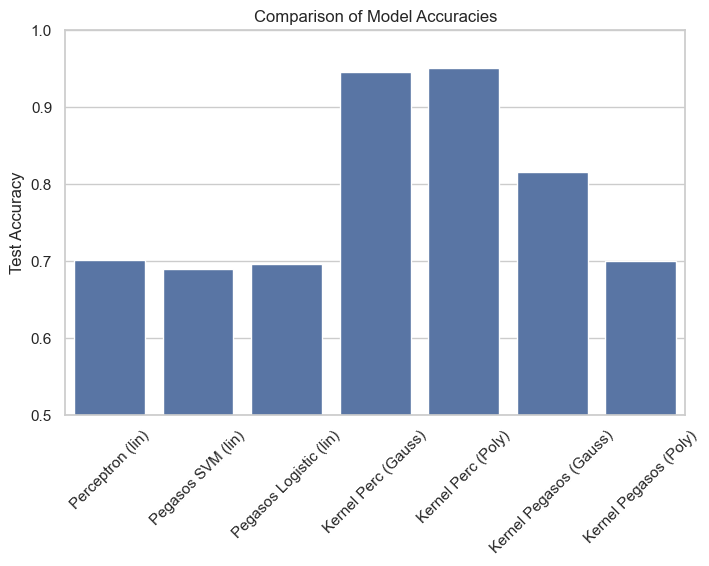

In [40]:
###########################################################
# Cell 7: Visualization of Results
###########################################################

model_names = [
    "Perceptron (lin)",
    "Pegasos SVM (lin)",
    "Pegasos Logistic (lin)",
    "Kernel Perc (Gauss)",
    "Kernel Perc (Poly)",
    "Kernel Pegasos (Gauss)",
    "Kernel Pegasos (Poly)"
]

# Suppose we've recorded the final test accuracies from each best model
test_accuracies = [
    0.701,  # placeholder, replace with your actual final test acc for Perceptron
    0.690,  # Pegasos SVM
    0.696,  # Pegasos Logistic
    0.946,  # Kernel Perceptron (Gaussian)
    0.951,  # Kernel Perceptron (Poly)
    0.815,  # Kernel Pegasos (Gaussian)
    0.70   # Kernel Pegasos (Poly)
]

plt.figure(figsize=(8,5))
sns.barplot(x=model_names, y=test_accuracies)
plt.xticks(rotation=45)
plt.ylim(0.5,1)
plt.ylabel("Test Accuracy")
plt.title("Comparison of Model Accuracies")
plt.show()
